Import dependencies:

In [1]:
import numpy as np
import numexpr as ne


import os

import importlib
import poppy
importlib.reload(poppy)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['font.size'] = 9

import astropy.io
import astropy.units as u

import scipy.interpolate
import scipy.signal
import scipy.optimize

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.WARN)



%matplotlib inline


Print the this notebook's current git commit

In [2]:
%%bash
git rev-parse HEAD


3c32ec4923f8226d389738726f2bb816bbaaec74


## Print system info

### Software versions

In [3]:
from  poppy.accel_math import  _USE_CUDA, _USE_NUMEXPR, _FFTW_AVAILABLE

print(_USE_CUDA, _USE_NUMEXPR,_FFTW_AVAILABLE)
print("current POPPY version: "+str(poppy.__version__))



True True True
current POPPY version: 0.6.2.dev1145


In [44]:
print(np.__version__)
print(np.__config__.show())

1.11.2
blas_mkl_info:
    libraries = ['mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/home/edouglas/miniconda3/envs/accelerate/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/edouglas/miniconda3/envs/accelerate/include']
blas_opt_info:
    libraries = ['mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/home/edouglas/miniconda3/envs/accelerate/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/edouglas/miniconda3/envs/accelerate/include']
openblas_lapack_info:
  NOT AVAILABLE
lapack_mkl_info:
    libraries = ['mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/home/edouglas/miniconda3/envs/accelerate/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/edouglas/miniconda3/envs/accelerate/include']
lapack_opt_info:
    li

In [45]:
print("NumExpr info")
print(ne.__version__)
ne.ncores,ne.nthreads,ne.show_config()

NumExpr info
2.6.1
mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/edouglas/miniconda3/envs/accelerate/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/edouglas/miniconda3/envs/accelerate/include']


(12, 8, None)

In [51]:
print("FFTW info")
print(pyfftw.version)


FFTW info
0.9.2


0.9.2


### Hardware info

In [6]:
%%bash
cat /proc/cpuinfo | grep 'model name' | uniq
cat /proc/cpuinfo | grep 'cpu family' | uniq
 lscpu | grep 'Model:' | uniq
 lscpu | egrep '^Thread|^Core|^Socket|^CPU\('



model name	: Intel(R) Xeon(R) CPU
cpu family	: 6
Model:                 85
CPU(s):                12
Thread(s) per core:    2
Core(s) per socket:    6
Socket(s):             1


In [43]:
%%bash
nvidia-smi



Fri May 11 15:43:54 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    41W / 300W |   2601MiB / 16152MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Benchmark some useful math

In [8]:
n=4096
y=np.ones([n,n],dtype=np.complex128)
x=2*np.ones([n,n],dtype=np.complex128)
z=9#2*np.ones([n,n])#*1.j



In [9]:
print("NumPy:")
%timeit np.exp((x**2 + y**2)/z)

try:
    import numba
    import cmath
    dtype=numba.complex128
    @numba.vectorize([dtype(dtype,dtype,dtype)],)
    def fexp(x, y,z):
        return cmath.exp((x**2 + y**2)/z)
    print("Numba optimized w/o GPU:")
    %timeit fexp(x,y,z) #numba optimized
except Exception as err:
    print(err)
    
try:
    import numba
    @numba.vectorize([numba.complex128(numba.float64,numba.float64,
                            numba.float64,numba.float64,
                            numba.float64,numba.float64)],
          target="parallel")
    
    def f_xyz_def(xr,xi,
         yr,yi,
         zr,zi):
        x=complex(xr,xi)

        y=complex(yr,yi)

        z=complex(zr,zi)
        return cmath.cos((x**2+y**2)/z) + 1j*cmath.sin((x**2+y**2)/z)
        #return cmath.exp((x**2+y**2)/z)
    print("Numba Optimized with GPU:")
    %timeit f_xyz_def(x.real,x.imag,y.real,y.imag,z.real,z.imag)
except Exception as err:
    print(err)


print("numexpr optimized:")
%timeit ne.evaluate("exp((x**2 + y**2)/z)")




NumPy:
1.43 s ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numba optimized w/o GPU:
967 ms ± 5.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numba Optimized with GPU:
212 ms ± 382 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
numexpr optimized:
130 ms ± 642 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
#confirm that exponents are faster than trigonometry

%timeit ne.evaluate("exp(x)")
%timeit ne.evaluate("cos(x)+1j*sin(x)")
%timeit np.exp(x)
%timeit np.cos(x)+1j*np.sin(x)

89.8 ms ± 664 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
991 ms ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
755 ms ± 33.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.48 s ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
try:
    import accelerate
    print("unplanned CUDA FFT:")
    %timeit accelerate.cuda.fft.ifft(y,out=x)
    plan=accelerate.cuda.fft.FFTPlan(y.shape,np.complex128,np.complex128)
    print("planned CUDA FFT:")
    %timeit plan.inverse(y,out=x)
except Exception as err:
    print(err)
    
try:
    import pyfftw
    print("pyFFTW 32 threads:")
    %timeit pyfftw.interfaces.numpy_fft.ifft2(y,threads=32)
    print("pyFFTW 16 threads:")
    %timeit pyfftw.interfaces.numpy_fft.ifft2(y,threads=16)
except Exception as err:
    print(err)
    
print("numpy FFT:")
%timeit np.fft.ifft2(y)

unplanned CUDA FFT:
140 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
planned CUDA FFT:
136 ms ± 4.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
794 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
804 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.26 s ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
# Test FFT shifts
%timeit np.fft.fftshift(x)
%timeit poppy.accel_math._fftshift(x)
array8192=np.ones([8192,8192],dtype=np.complex128)

npshift_t= %timeit -o np.fft.fftshift(array8192)

cudashift_t=%timeit -o poppy.accel_math._fftshift(array8192)



338 ms ± 346 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
128 ms ± 314 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.37 s ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
510 ms ± 29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Define test system

In [35]:
intermediate=  poppy.poppy_core.PlaneType.intermediate 
wavelen = 770e-9

D_prim = 2.37 * u.m
fr_pri = 7.8
fl_pri = D_prim * fr_pri

D_relay = 20 * u.mm
fl_m2 = fl_pri * D_relay / D_prim
fr_m3 = 20.
fl_m3 = fr_m3 * D_relay

def optsys(npix=1024,ratio=0.25):
    '''
    initiate a WFIRST-like 3 mirror system
    
    '''
    
    optsys = poppy.FresnelOpticalSystem(pupil_diameter=D_prim,
    						 npix=npix, beam_ratio=ratio)

    m1 = poppy.QuadraticLens(fl_pri, name='Primary')
    m2 = poppy.QuadraticLens(fl_m2, name='M2')
    m3 = poppy.QuadraticLens(fl_m3, name='M3')

    optsys.add_optic(poppy.CircularAperture(radius=D_prim.value/2))
    optsys.add_optic(m1)
    optsys.add_optic(m2, distance = fl_pri + fl_m2)
    optsys.add_optic(m3, distance = fl_m2 + fl_m3)

    optsys.add_optic(poppy.ScalarTransmission(planetype=intermediate,
    name='focus'),
    	 distance=fl_m3)
    return optsys
    


In [38]:
optsys()

In [39]:
test_sys= optsys()
psf_timing = %prun -r  -s  tottime test_sys.calcPSF(wavelength=wavelen, display_intermediates=False, return_intermediates=False)




In [ ]:
psf_timing.print_stats()

## Benchmark baseline optical with acceleration

In [21]:
#from astropy.table import Table
import pandas as pd
pixlist = pd.Series([2**4,2**5,2**6,2**7,2**8,2**9,700,2**10])#,2**11])



In [22]:
scenarios=[[False,False,False],
          [False,False,True],
          [False,True,True],
          [True,True,True],
          ]

In [23]:
timings={}
import importlib

for combo in scenarios:
    df = pd.DataFrame(np.zeros([pixlist.size,2]), index=pixlist, columns=["avg","std"])
    print(combo)
    poppy.accel_math._USE_CUDA  = combo[0]
    poppy.accel_math._USE_NUMEXPR  = combo[1]
    poppy.conf.use_fftw = combo[2]
    #reload libraries to make sure variables are set.
    importlib.reload(poppy.fresnel)
    importlib.reload(poppy.optics)
    importlib.reload(poppy)

    print(poppy.fresnel._USE_CUDA,poppy.fresnel._USE_CUDA,poppy.conf.use_fftw )
    for i,npix in enumerate(pixlist):
        test_optsys=optsys(npix=npix,ratio=0.25)
        time = %timeit -o test_optsys.calcPSF(wavelength=wavelen, display_intermediates=False, return_intermediates=False)
    
        df.iloc[i]["std"] = time.stdev
        df.iloc[i]["avg"] = time.average
    outname='cuda'+str(poppy.fresnel._USE_CUDA)+'NumExpr'+str(poppy.fresnel._USE_NUMEXPR)+'FFT'+str(poppy.conf.use_fftw)+'.csv'
    df.to_csv(outname,float_format="%3.3e")
    print(outname)
    psf_timing = %prun -r  -s  tottime test_optsys.calcPSF(display_intermediates=False, return_intermediates=False)
    psf_timing.print_stats()
    

[False, False, False]
False False False
35.3 ms ± 78.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
46.1 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
95 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
307 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.34 s ± 4.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.2 s ± 73.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.2 s ± 65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
41.9 s ± 252 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
cudaFalseNumExprFalseFFTFalse.csv
          37097 function calls (36953 primitive calls) in 41.857 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        8    9.203    1.150    9.203    1.150 accel_math.py:55(_exp)
       10    6.737    0.674    6.737    0.674 {built-in method numpy.fft.fftpack_lite.cfftf}
       29    4.926    0.170    4.926    0.

False False True
36.7 ms ± 610 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
45.6 ms ± 62.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
84.9 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
262 ms ± 953 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.18 s ± 47.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.18 s ± 555 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15 s ± 93.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
32.2 s ± 276 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
cudaFalseNumExprFalseFFTTrue.csv
          37380 function calls (37236 primitive calls) in 32.586 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        8    9.500    1.187    9.500    1.187 accel_math.py:55(_exp)
        6    4.165    0.694   12.248    2.041 fresnel.py:65(get_phasor)
       29    3.340    0.115    3.340    0.115 {method 'take' of 'numpy.ndarray' objects

        6    0.000    0.000    0.000    0.000 _methods.py:40(_all)
        3    0.000    0.000    0.000    0.000 quantity.py:1069(__len__)
        5    0.000    0.000    0.000    0.000 quantity.py:824(isscalar)
        1    0.000    0.000    0.000    0.000 hdulist.py:245(__len__)
        1    0.000    0.000    0.000    0.000 base.py:876(__init__)
       18    0.000    0.000    0.000    0.000 encoder.py:412(_iterencode)
        1    0.000    0.000    0.000    0.000 encoder.py:259(_make_iterencode)
        2    0.000    0.000    0.000    0.000 posixpath.py:367(abspath)
        1    0.000    0.000    0.000    0.000 genericpath.py:39(isdir)
        1    0.000    0.000    0.000    0.000 _collections_abc.py:657(get)
        8    0.000    0.000    0.000    0.000 {method 'decode' of 'bytes' objects}
        5    0.000    0.000    0.000    0.000 {method 'encode' of 'str' objects}
        9    0.000    0.000    0.000    0.000 {built-in method posix.fspath}
        7    0.000    0.000    0.000   

        1    0.000    0.000    0.000    0.000 _bootlocale.py:23(getpreferredencoding)
        8    0.000    0.000    0.000    0.000 {method 'decode' of 'bytes' objects}
        5    0.000    0.000    0.000    0.000 {method 'encode' of 'str' objects}
        3    0.000    0.000    0.000    0.000 quantity_helper.py:55(<lambda>)
        1    0.000    0.000    0.000    0.000 hdulist.py:245(__len__)
        4    0.000    0.000    0.000    0.000 base.py:237(_data_loaded)
        1    0.000    0.000    0.000    0.000 encoder.py:259(_make_iterencode)
        5    0.000    0.000    0.000    0.000 posixpath.py:39(_get_sep)
        1    0.000    0.000    0.000    0.000 genericpath.py:16(exists)
        1    0.000    0.000    0.000    0.000 genericpath.py:39(isdir)
        4    0.000    0.000    0.000    0.000 {method 'find' of 'str' objects}
        7    0.000    0.000    0.000    0.000 {built-in method builtins.issubclass}
        2    0.000    0.000    0.000    0.000 quantity_helper.py:29(<lamb

       19    0.000    0.000    0.000    0.000 driver.py:809(mem_finalize)
        9    0.000    0.000    0.561    0.062 compiler.py:600(<lambda>)
       14    0.000    0.000    0.000    0.000 card.py:271(value)
       49    0.000    0.000    0.000    0.000 card.py:507(is_blank)
       38    0.000    0.000    0.001    0.000 _methods.py:34(_prod)
       48    0.000    0.000    0.000    0.000 {method 'values' of 'mappingproxy' objects}
       19    0.000    0.000    0.013    0.001 driver.py:622(_attempt_allocation)
       18    0.000    0.000    0.000    0.000 errors.py:17(normalize_kernel_dimensions)
      102    0.000    0.000    0.000    0.000 core.py:970(<genexpr>)
       24    0.000    0.000    0.000    0.000 header.py:122(__contains__)
        6    0.000    0.000    0.000    0.000 fromnumeric.py:1987(all)
       24    0.000    0.000    0.000    0.000 inspect.py:2569(__init__)
       38    0.000    0.000    0.000    0.000 {built-in method _weakref.proxy}
        9    0.000    0.000  

In [25]:
pixlist

0      16
1      32
2      64
3     128
4     256
5     512
6     700
7    1024
dtype: int64

In [26]:
outname='cuda'+str(_USE_CUDA)+'NumExpr'+str(_USE_NUMEXPR)+'FFT'+str(poppy.conf.use_fftw)+'.csv'
df.to_csv(outname,float_format="%3.3e")
print(outname)

cudaTrueNumExprTrueFFTTrue.csv


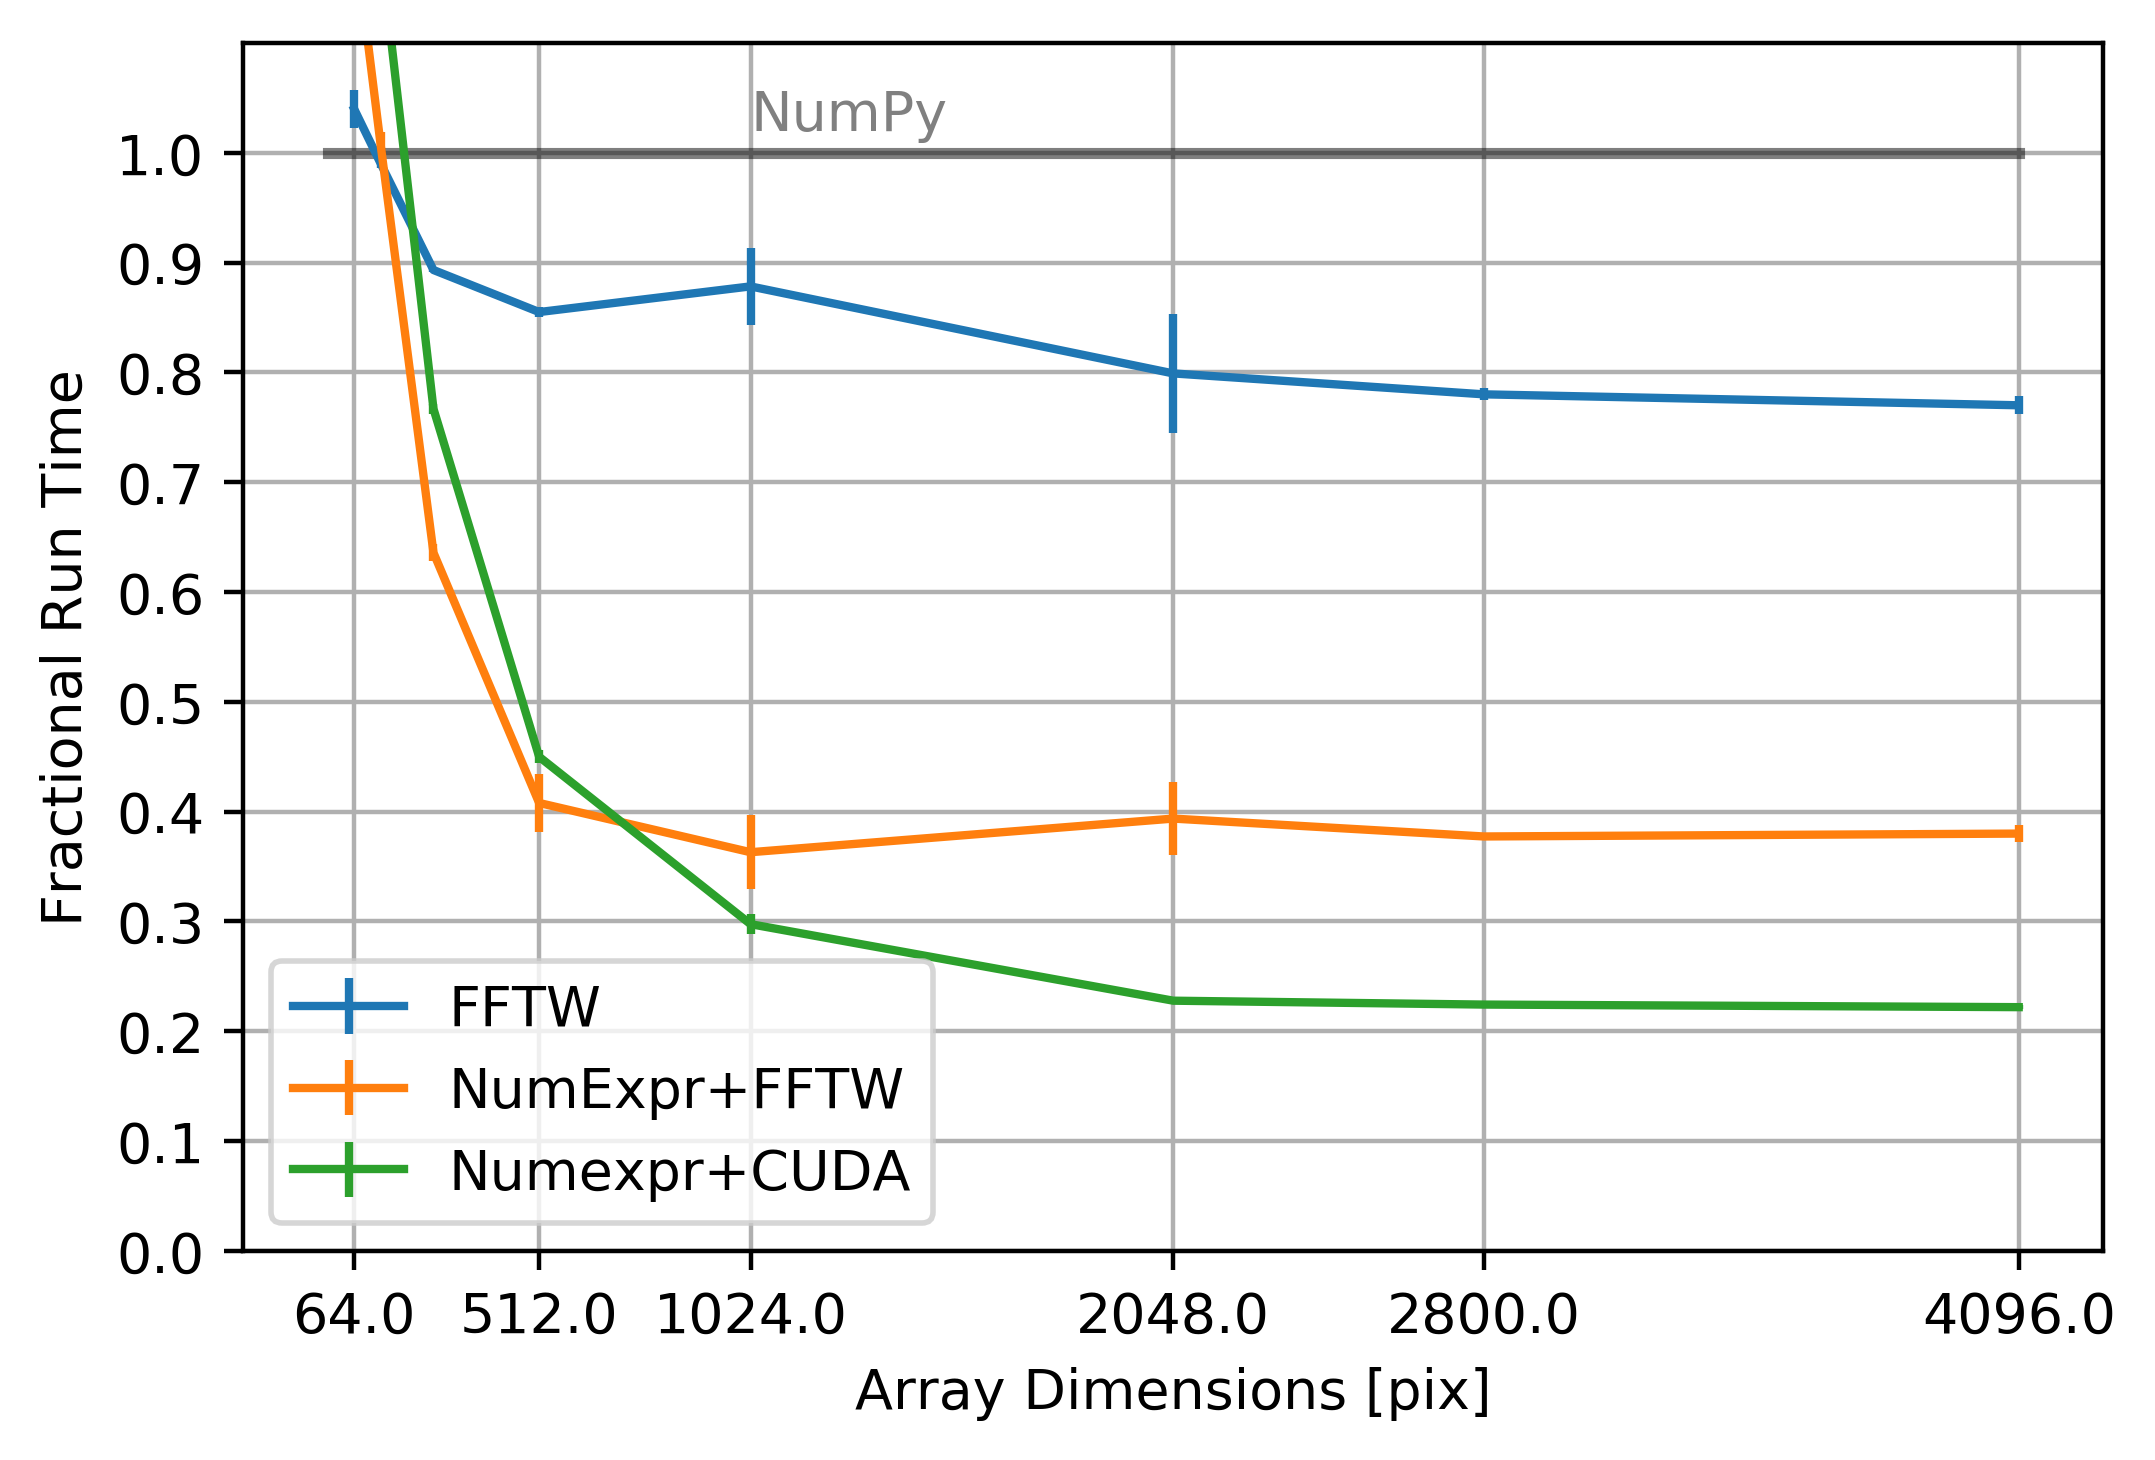

In [27]:
plt.figure(dpi=400)
ax=plt.subplot(111)


y=pd.read_csv('cuda'+str(False)+'NumExpr'+str(False)+'FFT'+str(False)+'.csv',index_col=0)
#y["avg"].plot.bar(yerr=y["std"],
#                       xticks=pixlist,label="NumPy",color="orange",linestyle="--",
#                   alpha=.7,ax=ax)


y_FFTW=pd.read_csv('cuda'+str(False)+'NumExpr'+str(False)+'FFT'+str(True)+'.csv',index_col=0)

#ax=y_cuda_numexpr["avg"].plot.bar(yerr=y_cuda_numexpr["std"],label="NumExpr+CUDA")
ax.errorbar(pixlist,y_FFTW["avg"]/y["avg"],
            yerr=y_FFTW["avg"]/y["avg"]*np.sqrt((y_FFTW["std"]/y_FFTW["avg"])**2+(y["std"]/y["avg"])**2),
            label="FFTW", )

y_numexpr=pd.read_csv('cuda'+str(False)+'NumExpr'+str(True)+'FFT'+str(True)+'.csv',index_col=0)
#y_cuda["avg"].plot.bar(yerr=y_cuda["std"],
#                       xticks=pixlist,label="CUDA",color="orange",alpha=.7,ax=ax)

ax.errorbar(pixlist,y_numexpr["avg"]/y["avg"],
            yerr=y_numexpr["avg"]/y["avg"]*np.sqrt((y_numexpr["std"]/y_numexpr["avg"])**2+(y["std"]/y["avg"])**2),
            label="NumExpr+FFTW",)

y_all=pd.read_csv('cuda'+str(True)+'NumExpr'+str(True)+'FFT'+str(True)+'.csv',index_col=0)
#y_cuda["avg"].plot.bar(yerr=y_cuda["std"],
#                       xticks=pixlist,label="CUDA",color="orange",alpha=.7,ax=ax)

ax.errorbar(pixlist,y_all["avg"]/y["avg"],
            yerr=y_all["avg"]/y["avg"]*np.sqrt((y_all["std"]/y_all["avg"])**2+(y["std"]/y["avg"])**2),

            label="Numexpr+CUDA",  )



ax.plot([0,np.max(pixlist)],[1,1],linewidth=2,alpha=.5,color="black")
ax.text(256,1.02,"NumPy",color="gray")
ax.set_xticks([pixlist[0]]+list(pixlist[3:]))
#ax.set_xticks(range(len(pixlist)))
ax.set_xticklabels(ax.get_xticks()/test_optsys.beam_ratio)
ax.set_yticks(np.arange(0,1.1,.1))
ax.set_ylabel("Fractional Run Time")
plt.legend()
plt.grid()
plt.xlabel("Array Dimensions [pix]")
plt.ylim([0,1.1])
#plt.yscale("log")
plt.savefig("benchmarks%icores.pdf"%(ne.ncores),bbox_inches="tight")

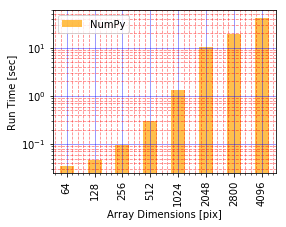

In [40]:
plt.figure(figsize=[4,3])
ax=plt.subplot(111)

ticks=np.int_(pixlist*4)
y=pd.read_csv('cuda'+str(False)+'NumExpr'+str(False)+'FFT'+str(False)+'.csv',index_col=0)
y["avg"].plot.bar(yerr=y["std"],
                       #ticks=ticks,
                  label="NumPy",color="orange",linestyle="--",
                   alpha=.7,ax=ax)

#ax.text(256,1.02,"NumPy",color="gray")
ax.set_ylabel("Run Time [sec]")
plt.legend()
plt.minorticks_on()

plt.grid(b=True, which='major', color='b', linestyle='-',alpha=.5)

plt.grid(b=True, which='minor', color='r', linestyle='--',alpha=.5)
plt.xlabel("Array Dimensions [pix]")
#plt.yscale("log")
plt.yscale("log")
ax.set_xticklabels(ticks)


plt.savefig("NumPy_runtime%icores.pdf"%(ne.ncores),bbox_inches="tight")

### where's the remaining bottleneck?

NumExpr evalutations still dominate

In [41]:
psf_timing = %prun -r  -s  tottime  optsys(npix=4096,ratio=0.25).calcPSF(display_intermediates=False, return_intermediates=False)
    

          46012 function calls (45801 primitive calls) in 171.340 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       39   40.309    1.034   40.312    1.034 necompiler.py:732(evaluate)
        2   25.394   12.697   84.337   42.169 fresnel.py:643(_propagate_ptp)
       85   20.713    0.244   20.714    0.244 driver.py:255(safe_cuda_api_call)
        9   19.970    2.219   19.970    2.219 {method 'copy' of 'numpy.ndarray' objects}
        8   14.312    1.789   59.040    7.380 poppy_core.py:175(__imul__)
        2   11.085    5.542   31.278   15.639 _utils.py:29(_Xfftn)
        2    6.037    3.018   37.583   18.791 fresnel.py:388(_inv_fft)
        6    5.897    0.983    5.897    0.983 {method 'take' of 'numpy.ndarray' objects}
        5    4.382    0.876   11.912    2.382 fresnel.py:365(_fft)
        1    3.734    3.734    3.734    3.734 {built-in method numpy.core.multiarray.where}
        1    2.839    2.839    8.656    8.6

       39    0.000    0.000    0.000    0.000 hdulist.py:687(_positive_index_of)
       24    0.000    0.000    0.000    0.000 header.py:122(__contains__)
       96    0.000    0.000    0.000    0.000 core.py:588(bases)
       58    0.000    0.000    0.000    0.000 dummyarray.py:83(get_offset)
       76    0.000    0.000    0.000    0.000 core.py:1462(is_unity)
        7    0.000    0.000    0.000    0.000 card.py:895(_format_value)
       65    0.000    0.000    0.000    0.000 {method 'endswith' of 'str' objects}
        5    0.000    0.000    0.000    0.000 fresnel.py:1050(add_optic)
      102    0.000    0.000    0.000    0.000 core.py:595(powers)
       19    0.000    0.000    0.000    0.000 card.py:424(comment)
        3    0.000    0.000  129.591   43.197 decorators.py:873(propagate_fresnel)
        9    0.000    0.000    0.000    0.000 numpy_support.py:85(from_dtype)
        6    0.000    0.000    0.000    0.000 core.py:833(_apply_equivalencies)
       37    0.000    0.000    0.

In [59]:
psf_timing = %prun -r  -s  tottime  optsys(npix=512,ratio=0.25).calcPSF(display_intermediates=False, return_intermediates=False)



## Talbot Effect Illustration

16.0 m


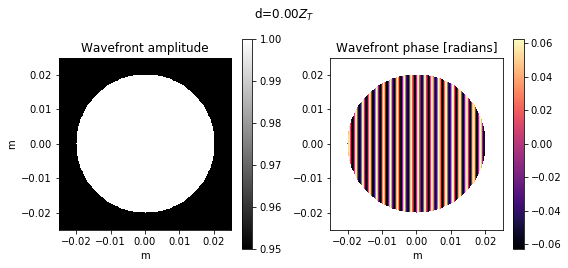

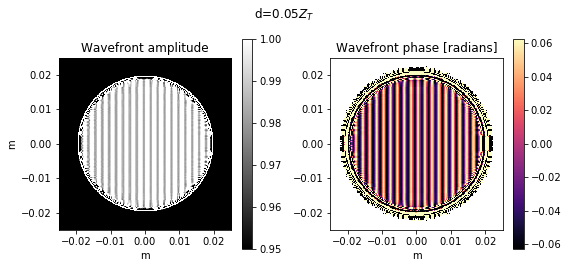

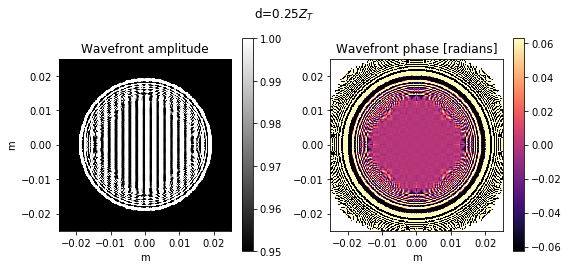

In [52]:
import poppy
import astropy.units as u
sineWFE=poppy.wfe.SineWaveWFE(spatialfreq=500,amplitude=5e-9)
wf_f = poppy.fresnel.FresnelWavefront(beam_radius=2*u.cm,wavelength=0.5*u.um,npix=256,oversample=8)
wf_f*=sineWFE
Z_t=2*((1/sineWFE.sine_spatial_freq))**2/wf_f.wavelength
       
       
wf_f *= poppy.CircularAperture(radius=wf_f.diam/2)
wf_f.propagate_fresnel(Z_t/10000.)


plt.figure(figsize=[8,4])
ax=wf_f.display(what="both",imagecrop=0.05,colorbar=True)
plt.suptitle("d=%.2f$Z_T$"%(wf_f.z/Z_t).decompose())



max_phase=6.28*(sineWFE.sine_amplitude/wf_f.wavelength).decompose()
amp_min=0.95
ax[0].images[0].set_clim(amp_min,1)
ax[1].images[0].set_clim(-max_phase,max_phase)
ax[1].images[0].set_cmap(plt.cm.magma)

plt.tight_layout()
plt.savefig("zt0.pdf",bbox_inches="tight")



plt.figure(figsize=[8,4])

wf_f.propagate_fresnel(Z_t*.05-wf_f.z)
ax=wf_f.display(what="both",imagecrop=0.05,colorbar=True)
ax[0].images[0].set_clim(amp_min,1)

ax[1].images[0].set_clim(-max_phase,max_phase)
ax[1].images[0].set_cmap(plt.cm.magma)
plt.suptitle("d=%.2f$Z_T$"%(wf_f.z/Z_t).decompose())

plt.tight_layout()
plt.savefig("zt1.pdf",bbox_inches="tight")


wf_f.propagate_fresnel(Z_t*.25-wf_f.z)
plt.figure(figsize=[8,4])
ax=wf_f.display(what="both",imagecrop=0.05,colorbar=True)
ax[0].images[0].set_clim(amp_min,1)

ax[1].images[0].set_clim(-max_phase,max_phase)
ax[1].images[0].set_cmap(plt.cm.magma)
plt.suptitle([(wf_f.z/Z_t).decompose(),np.std(wf_f.amplitude[wf_f.amplitude>1e-9])])
plt.tight_layout()


plt.suptitle("d=%.2f$Z_T$"%(wf_f.z/Z_t).decompose())



plt.tight_layout()
plt.savefig("zt2.pdf",bbox_inches="tight")
print(Z_t.decompose())

# Old:

commit:4d86854bc2e709d7415ac8e9075098c7f9b4dc16

```%timeit  wfirst_optsys.calcPSF(wavelength=wavelen, display_intermediates=False, return_intermediates=False)```

```
5.8 s ± 58.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
In [16]:
```

commit:8049b9257a2239944f3ca5358462580d4a47804b
```
5.66 s ± 28.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
In [8]:
```getphasor percall: 0.353




In [ ]:
plt.figure(figsize=[4,4])
x=np.array([1024,4096,8192])
y_numexpr=np.array([0.959,20.5,82])
y_numexpr_err=np.array([0.0183,0.726,0.465])

y=np.array([1.58,32.2,128])
y_err=np.array([0.036,0.710,3.28])

y_fftw=np.array([1.21,24,93])
y_fftw_err=np.array([0.032,0.249,0.791])



y_numexpr_cuda=np.array([0.497,9.23 ,40])
y_numexpr_cuda_err=np.array([0.0158,0.0516,0.387])
plt.errorbar(x,y/y,fmt='.-',label="numpy")#,yerr=y_err)


plt.errorbar(x,y_fftw/y,label="FFTW",fmt='.-')#,yerr=y_numexpr_err)

plt.errorbar(x,y_numexpr/y,fmt='.-',label="FFTW+NumExpr",)#,yerr=y_numexpr_err)




plt.errorbar(x,y_numexpr_cuda/y,label="cuda+NumExpr",fmt='.-')#,yerr=y_numexpr_cuda_err)
#plt.yscale()
plt.legend()
plt.ylabel("numpy normalized time")
plt.xlabel("array dimension")
plt.title("3 surface optical system")

In [ ]:
%%prun
poppy.conf.use_cuda=False
psf = wfirst_optsys.calcPSF(wavelength=wavelen, display_intermediates=False, return_intermediates=False)


In [ ]:
poppy.display_psf(psf)


In [ ]:
plt.figure(figsize=(12,8))
psf = wfirst_optsys.calcPSF(wavelength=wavelen, display_intermediates=True, return_intermediates=True)

In [ ]:
#exit_wf = waves[-1]
plt.imshow(np.log10(wf.intensity), cmap='gray', vmin=-6, vmax=0)
plt.colorbar()

## Old benchmarks:

##  83e5e2d3be3240c2867a02f8e89c7b1802cb3a4e


environment accelerate 83e5e2d3be3240c2867a02f8e89c7b1802cb3a4e:

`ne.ncores,ne.nthreads,ne.show_config()`

```mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/edouglas/miniconda3/envs/anaconda/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/edouglas/miniconda3/envs/anaconda/include']
Out[29]:
(8, 8, None)
```

### standard install with np.fft
```
1.58 s ± 36.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
32.2 s ± 710 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2min 8s ± 3.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
```
### standard install with pyfftw:
```
1.21 s ± 32.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
24 s ± 249 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 34s ± 791 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

```
### NumExpr but no cuda:


```
959 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
20.5 s ± 726 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 22s ± 465 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

### NumExpr +  cuda, 2x faster:
```
497 ms ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.23 s ± 51.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
40 s ± 387 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

In [ ]:
exit_wf.n